In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# https://www.kaggle.com/datasets/abrambeyer/openintro-possum

# Немного теории

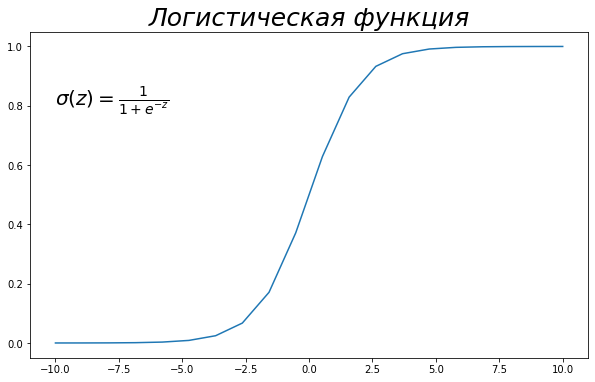

In [2]:
# Напоминание, как выглядит логит-функция
import math

# задаем переменные через функцию
z = np.linspace(-10, 10, 20)
sigma = [1/(1 + math.exp(-i)) for i in z]

# отрисовываем логит-функцию
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(z, sigma)
plt.title('Логистическая функция', fontstyle='italic', fontsize=25)
ax.text(-10, 0.8, r'$\sigma(z) = \frac{1}{1 + e^{-z}}$', fontsize=20)
plt.show()

# Загрузка и предобработка датасета

In [3]:
df_possum = pd.read_csv("possum.csv")
df_possum.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [4]:
# бинаризируем переменные
df_possum.sex = df_possum.sex.map({'m': 1, 'f': 0})
df_possum.Pop = df_possum.Pop.map({'Vic': 1, 'other': 0})

In [5]:
# проверяем на Nan
df_possum.isna().any()

case        False
site        False
Pop         False
sex         False
age          True
hdlngth     False
skullw      False
totlngth    False
taill       False
footlgth     True
earconch    False
eye         False
chest       False
belly       False
dtype: bool

In [6]:
# вставляем пропущенные значения средними по столбцу
df_possum.age.fillna(df_possum['age'].mean(), inplace=True)
df_possum.footlgth.fillna(df_possum['footlgth'].mean(), inplace=True)
df_possum.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,1,1,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,1,0,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,1,0,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,1,0,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,1,0,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


# Логистическая регрессия

## Определяем пол

In [7]:
# удаляем столбцы, которые не нужны для дальнейшего анализа
df_possum_sex = df_possum.drop(['case', 'Pop', 'age', 'site'], axis=1)
df_possum_sex.head()

,sex,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


In [8]:
# отбираем Х и у
X = df_possum_sex.iloc[:, 1:]
y = df_possum_sex['sex']
# нормализуем данные
X = (X - X.mean(axis=0)) / (X.std(axis=0, ddof=1))
# Делим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=777, stratify=y)
X.head()

,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,0.418967,1.129414,0.443456,-0.515236,1.381091,1.549925,0.146468,0.488855,1.235889
1,-0.028792,0.230083,1.023428,-0.260072,0.923835,0.746884,0.908101,0.733282,0.149699
2,0.390982,1.000938,1.951384,1.015752,1.586856,0.917226,0.432080,1.466565,0.511762
3,0.167102,0.069488,1.139423,0.505422,1.746896,0.990230,0.146468,0.488855,0.511762
4,-0.308642,-0.187464,-0.368506,-0.515236,0.580893,1.233576,0.051264,0.733282,0.149699


In [9]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

y_predicted = logreg_model.predict(X_test)
print(f'Precision: {metrics.precision_score(y_test, y_predicted)}')
print(f'Recall: {metrics.recall_score(y_test, y_predicted)}')
print(f'F - мера {metrics.f1_score(y_test, y_predicted)}')

Precision: 0.8235294117647058
Recall: 0.7368421052631579
F - мера 0.7777777777777778


In [10]:
logreg_model = LogisticRegression(penalty='l2')

grid_cv = GridSearchCV(logreg_model, param_grid={
                       'C': np.arange(0.01, 1, 0.01)}, cv=10, n_jobs=-1)
grid_cv.fit(X_train, y_train)

opt_C = grid_cv.best_estimator_.C
print(f'opt C = {opt_C}')

opt C = 0.01


In [11]:
best_logreg_model = LogisticRegression(penalty='l2', C=opt_C)
best_logreg_model.fit(X_train, y_train)

y_predicted = best_logreg_model.predict(X_test)
print(f'Precision: {metrics.precision_score(y_test, y_predicted)}')
print(f'Recall: {metrics.recall_score(y_test, y_predicted)}')
print(f'F - мера {metrics.f1_score(y_test, y_predicted)}')

Precision: 0.59375
Recall: 1.0
F - мера 0.7450980392156863


## Определяем место ловли опоссума

In [12]:
# удаляем столбцы, которые не нужны для дальнейшего анализа
df_possum_site = df_possum.drop(['case'], axis=1)
X = df_possum_site.iloc[:, 1:]
y = df_possum_site['site']
# нормализуем данные
X = (X - X.mean(axis=0)) / (X.std(axis=0, ddof=1))
X.head()

,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1.117473,0.835548,2.203866,0.418967,1.129414,0.443456,-0.515236,1.381091,1.549925,0.146468,0.488855,1.235889
1,1.117473,-1.185312,1.146010,-0.028792,0.230083,1.023428,-0.260072,0.923835,0.746884,0.908101,0.733282,0.149699
2,1.117473,-1.185312,1.146010,0.390982,1.000938,1.951384,1.015752,1.586856,0.917226,0.432080,1.466565,0.511762
3,1.117473,-1.185312,1.146010,0.167102,0.069488,1.139423,0.505422,1.746896,0.990230,0.146468,0.488855,0.511762
4,1.117473,-1.185312,-0.969701,-0.308642,-0.187464,-0.368506,-0.515236,0.580893,1.233576,0.051264,0.733282,0.149699


In [13]:
# Делим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=777, stratify=y)

In [14]:
logreg_model = LogisticRegression(penalty='l2')

grid_cv = GridSearchCV(logreg_model, param_grid={
                       'C': np.arange(0.01, 1, 0.01)}, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

opt_C = grid_cv.best_estimator_.C
print(f'opt C = {opt_C}')

best_logreg_model = LogisticRegression(penalty='l2', C=opt_C)
best_logreg_model.fit(X_train, y_train)

y_predicted = best_logreg_model.predict(X_test)
print(f"F - мера {metrics.f1_score(y_test, y_predicted, average='weighted')}")

opt C = 0.14
F - мера 0.6985119047619047


<AxesSubplot:xlabel='site', ylabel='Count'>

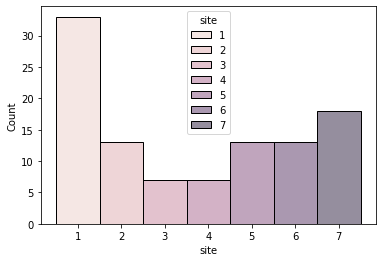

In [15]:
import seaborn as sns

sns.histplot(data=df_possum, x="site", discrete=True, hue="site")

## Определяем популяцию опоссума

In [16]:
# удаляем столбцы, которые не нужны для дальнейшего анализа
df_possum_site = df_possum.drop(['case', 'site'], axis=1)
X = df_possum_site.drop(['Pop'], axis=1)
y = df_possum_site['Pop']
# нормализуем данные
X = (X - X.mean(axis=0)) / (X.std(axis=0, ddof=1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=777, stratify=y)

logreg_model = LogisticRegression(penalty='l2')

grid_cv = GridSearchCV(logreg_model, param_grid={
                       'C': np.arange(0.01, 1, 0.01)}, cv=10, n_jobs=-1)
grid_cv.fit(X_train, y_train)

opt_C = grid_cv.best_estimator_.C
print(f'opt C = {opt_C}')

best_logreg_model = LogisticRegression(penalty='l2', C=opt_C)
best_logreg_model.fit(X_train, y_train)

y_predicted = best_logreg_model.predict(X_test)
print(f"F - мера {metrics.f1_score(y_test, y_predicted)}")

opt C = 0.08
F - мера 0.962962962962963


<AxesSubplot:xlabel='Pop', ylabel='Count'>

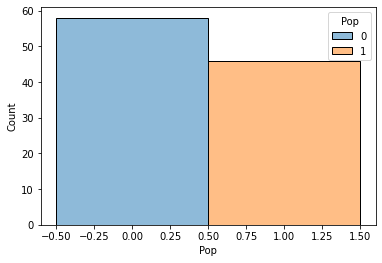

In [17]:
sns.histplot(data=df_possum, x="Pop", discrete=True, hue="Pop")